In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## 1. Первичная обработка данных

In [298]:
train = pd.read_csv('train_hw.csv')
test = pd.read_csv('test_hw.csv')

print(f"Train shape: {train.shape}, Test shape: {test.shape}\n")

Train shape: (1168, 81), Test shape: (292, 80)



In [299]:
from sklearn.model_selection import train_test_split

X = train.drop('SalePrice', axis=1)  
y = np.log1p(train['SalePrice']) 

In [300]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [301]:
def analyze_data(df, name=""):
    print(f"=== Анализ {name} датасета ===")

    num_cols = df.select_dtypes(include=np.number).columns
    print("\nЧисловые колонки:")
    print(df[num_cols].describe().T)

    cat_cols = df.select_dtypes(include='object').columns
    print("\nКатегориальные колонки:")
    print(df[cat_cols].describe(include='object').T)

    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
    print("\nПропущенные значения:")
    print(missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False))

In [270]:
analyze_data(train, "Train")
analyze_data(test, "Test")

=== Анализ Train датасета ===

Числовые колонки:
                count           mean           std      min        25%  \
Id             1168.0     584.500000    337.316864      1.0     292.75   
MSSubClass     1168.0      56.250000     42.354899     20.0      20.00   
LotFrontage     959.0      70.106361     23.682114     21.0      60.00   
LotArea        1168.0   10206.727740   7324.819093   1300.0    7526.25   
OverallQual    1168.0       6.101884      1.404753      1.0       5.00   
OverallCond    1168.0       5.547089      1.092708      1.0       5.00   
YearBuilt      1168.0    1971.819349     30.049386   1875.0    1954.00   
YearRemodAdd   1168.0    1984.894692     20.661968   1950.0    1966.00   
MasVnrArea     1160.0     104.780172    181.847363      0.0       0.00   
BsmtFinSF1     1168.0     452.773973    469.929912      0.0       0.00   
BsmtFinSF2     1168.0      44.457192    157.437949      0.0       0.00   
BsmtUnfSF      1168.0     574.379281    443.886899      0.0    

In [302]:
def remove_outliers(df):
    numerical_df = df.select_dtypes(include=[np.number])

    Q1 = numerical_df.quantile(0.25)
    Q3 = numerical_df.quantile(0.75)
    IQR = Q3 - Q1

    filtered_df = df[~((numerical_df < (Q1 - 1.5 * IQR)) | (numerical_df > (Q3 + 1.5 * IQR))).any(axis=1)]

    return filtered_df

In [303]:
X_train_filtered = remove_outliers(X_train)
y_train_filtered = y_train[X_train_filtered.index]
X_valid_filtered = remove_outliers(X_valid)
y_valid_filtered = y_valid[X_valid_filtered.index]

In [304]:
def preprocess_data(df):
    # Удаление колонок с более чем 50% пропусков
    missing_pct = df.isnull().mean() * 100
    cols_to_drop = missing_pct[missing_pct > 50].index
    df = df.drop(cols_to_drop, axis=1)

    num_cols = df.select_dtypes(include=np.number).columns
    cat_cols = df.select_dtypes(include='object').columns

    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

    df = pd.get_dummies(df, drop_first=True)

    return df

In [305]:
X_train_filtered = preprocess_data(X_train_filtered)
X_test_filtered = preprocess_data(X_valid_filtered)

common_cols = X_train_filtered.columns.intersection(X_test_filtered.columns)
X_train_filtered = X_train_filtered[common_cols]
X_valid_filtered = X_test_filtered[common_cols]
y_valid_filtered = y_valid_filtered.loc[X_test_filtered.index]
y_train_filtered = y_train_filtered.loc[X_train_filtered.index]
test_columns = X_train_filtered.columns

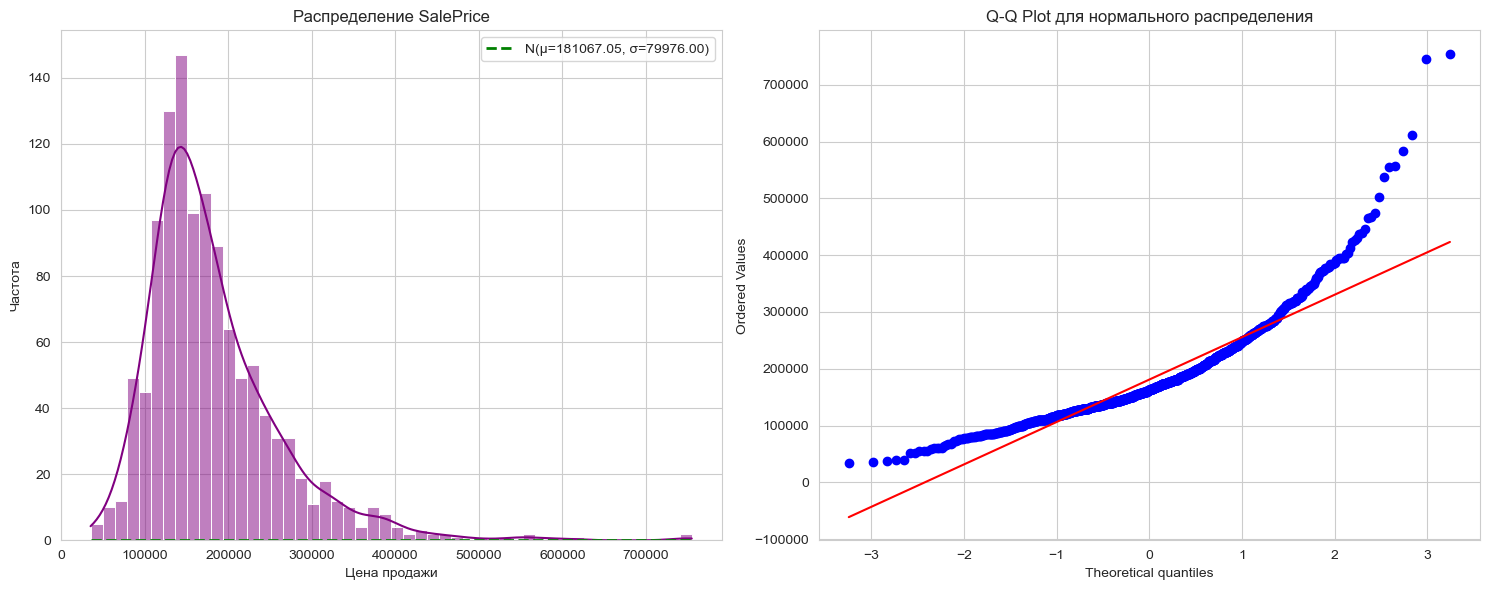

Тест Шапиро-Уилка на нормальность:
W = 0.8703, p-value = 0.0000


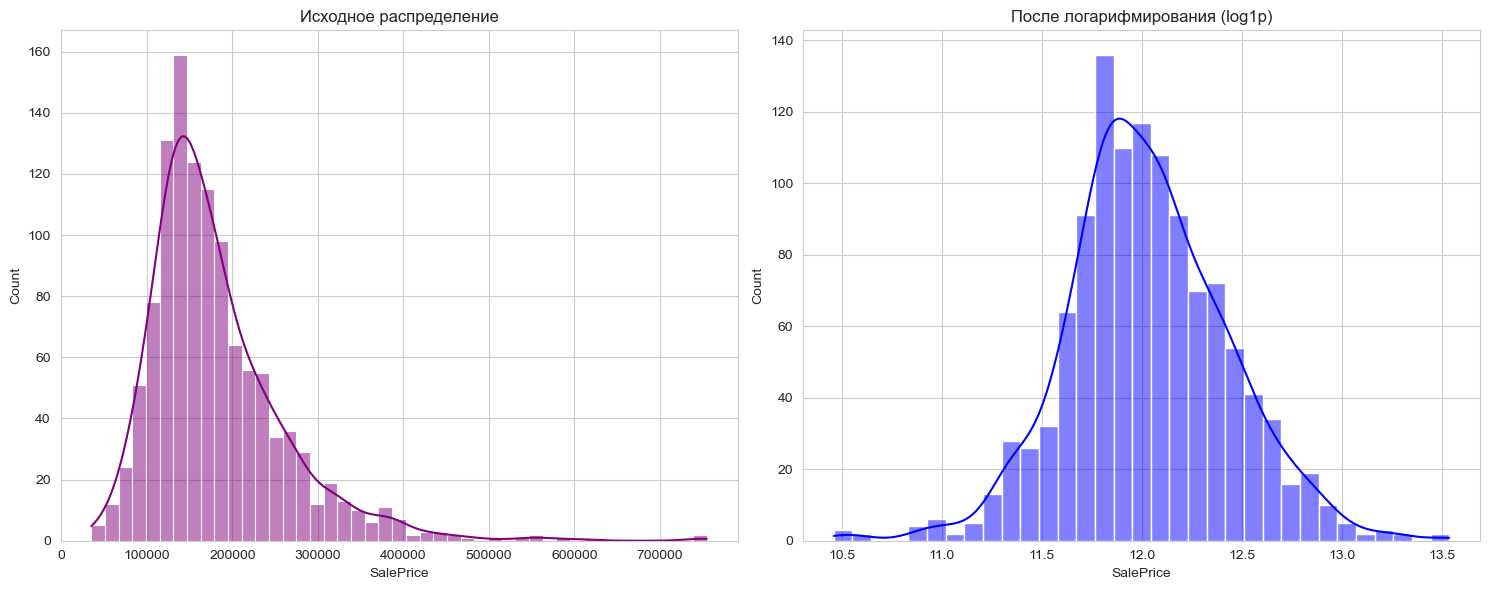


После логарифмирования:
W = 0.9906, p-value = 0.0000


In [275]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(train['SalePrice'], kde=True, color='purple', bins=50)
plt.title('Распределение SalePrice')
plt.xlabel('Цена продажи')
plt.ylabel('Частота')

mu, sigma = stats.norm.fit(train['SalePrice'])
x = np.linspace(train['SalePrice'].min(), train['SalePrice'].max(), 100)
y = stats.norm.pdf(x, mu, sigma)
plt.plot(x, y, 'g--', linewidth=2, label=f'N(μ={mu:.2f}, σ={sigma:.2f})')
plt.legend()

plt.subplot(1, 2, 2)
stats.probplot(train['SalePrice'], dist="norm", plot=plt)
plt.title('Q-Q Plot для нормального распределения')
plt.tight_layout()
plt.show()

shapiro_test = stats.shapiro(train['SalePrice'])
print(f"Тест Шапиро-Уилка на нормальность:\nW = {shapiro_test[0]:.4f}, p-value = {shapiro_test[1]:.4f}")

if shapiro_test[1] < 0.05:
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(train['SalePrice'], kde=True, color='purple')
    plt.title('Исходное распределение')

    plt.subplot(1, 2, 2)
    log_price = np.log1p(train['SalePrice'])
    sns.histplot(log_price, kde=True, color='blue')
    plt.title('После логарифмирования (log1p)')

    plt.tight_layout()
    plt.show()

    shapiro_log = stats.shapiro(log_price)
    print(f"\nПосле логарифмирования:\nW = {shapiro_log[0]:.4f}, p-value = {shapiro_log[1]:.4f}")

## Исследование данных

C:\Users\2005k\AppData\Local\Temp\ipykernel_14576\2225919957.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dwelling_types.index, y=dwelling_types.values, palette='viridis')
C:\Users\2005k\AppData\Local\Temp\ipykernel_14576\2225919957.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dwelling_prices.index, y=dwelling_prices.values, palette='magma')


Text(0, 0.5, 'Средняя цена ($)')

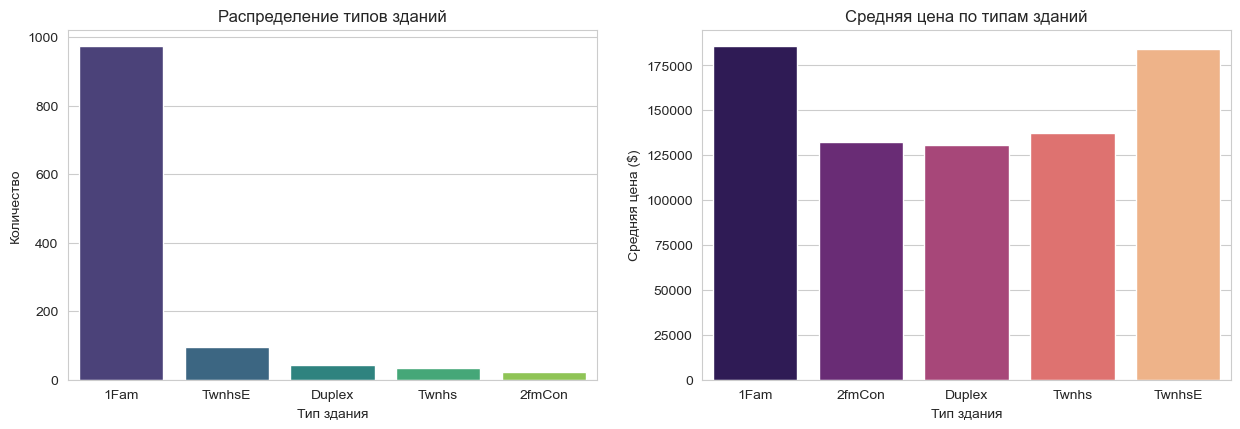

In [276]:
# 1. Распределение типов зданий и их влияние на цену
plt.figure(figsize=(15, 10))

# График 1: Распределение типов зданий
plt.subplot(2, 2, 1)
dwelling_types = train['BldgType'].value_counts()
sns.barplot(x=dwelling_types.index, y=dwelling_types.values, palette='viridis')
plt.title('Распределение типов зданий', fontsize=12)
plt.xlabel('Тип здания')
plt.ylabel('Количество')

# График 2: Средняя цена по типам зданий
plt.subplot(2, 2, 2)
dwelling_prices = train.groupby('BldgType')['SalePrice'].mean()
sns.barplot(x=dwelling_prices.index, y=dwelling_prices.values, palette='magma')
plt.title('Средняя цена по типам зданий', fontsize=12)
plt.xlabel('Тип здания')
plt.ylabel('Средняя цена ($)')

C:\Users\2005k\AppData\Local\Temp\ipykernel_14576\560264723.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=zoning_prices.index, y=zoning_prices.values, palette='plasma')


Text(0, 0.5, 'Средняя цена ($)')

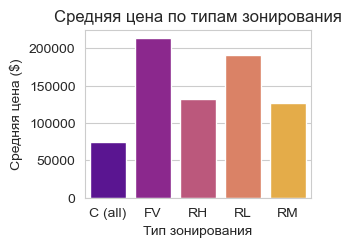

In [56]:
# 2. Влияние зонирования на цену
plt.subplot(2, 2, 3)
zoning_prices = train.groupby('MSZoning')['SalePrice'].mean()
sns.barplot(x=zoning_prices.index, y=zoning_prices.values, palette='plasma')
plt.title('Средняя цена по типам зонирования', fontsize=12)
plt.xlabel('Тип зонирования')
plt.ylabel('Средняя цена ($)')

C:\Users\2005k\AppData\Local\Temp\ipykernel_14576\612861973.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=street_prices.index, y=street_prices.values, palette='viridis')


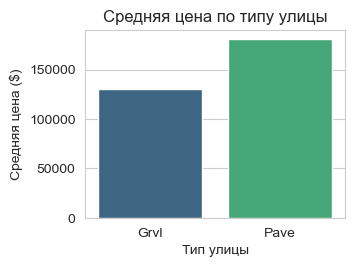

In [57]:
# 3. Влияние типа улицы и переулка
plt.subplot(2, 2, 4)
street_prices = train.groupby('Street')['SalePrice'].mean()
sns.barplot(x=street_prices.index, y=street_prices.values, palette='viridis')
plt.title('Средняя цена по типу улицы', fontsize=12)
plt.xlabel('Тип улицы')
plt.ylabel('Средняя цена ($)')

plt.tight_layout()
plt.show()

C:\Users\2005k\AppData\Local\Temp\ipykernel_14576\2437172321.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shape_prices.index, y=shape_prices.values, palette='rocket')
C:\Users\2005k\AppData\Local\Temp\ipykernel_14576\2437172321.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contour_prices.index, y=contour_prices.values, palette='mako')


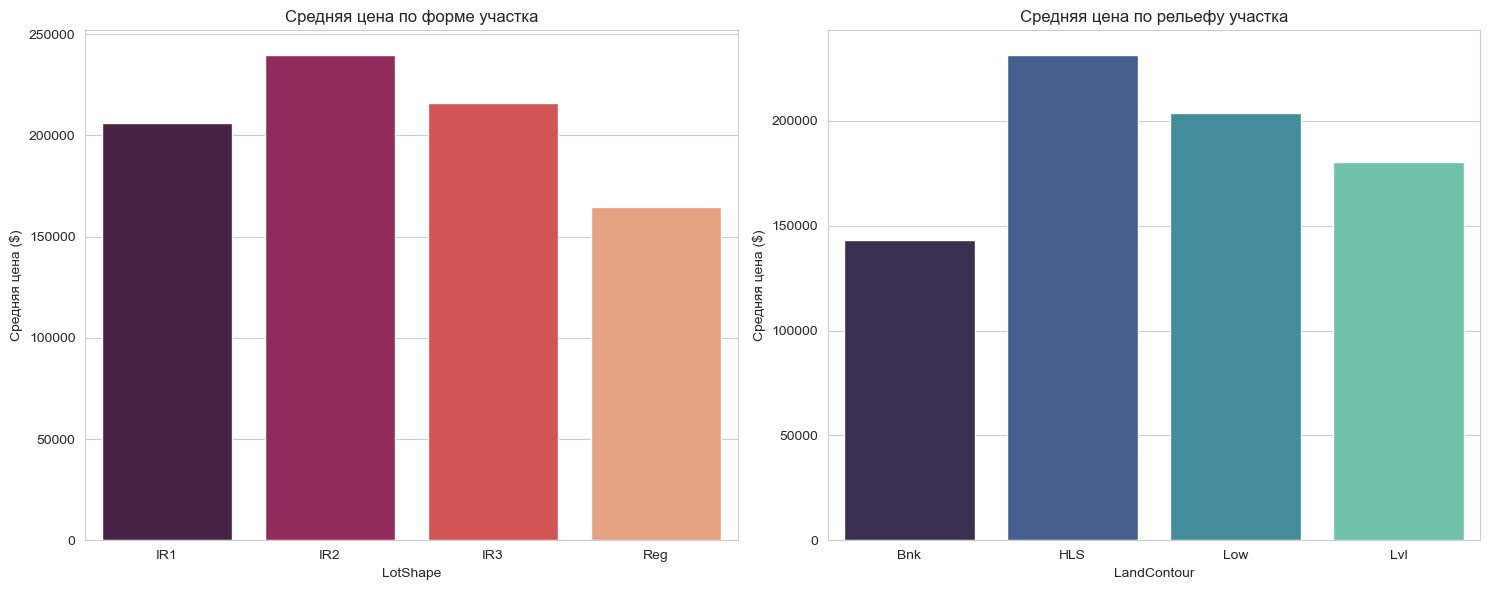

In [58]:
# 4. Влияние формы участка и рельефа
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
shape_prices = train.groupby('LotShape')['SalePrice'].mean()
sns.barplot(x=shape_prices.index, y=shape_prices.values, palette='rocket')
plt.title('Средняя цена по форме участка')
plt.ylabel('Средняя цена ($)')

plt.subplot(1, 2, 2)
contour_prices = train.groupby('LandContour')['SalePrice'].mean()
sns.barplot(x=contour_prices.index, y=contour_prices.values, palette='mako')
plt.title('Средняя цена по рельефу участка')
plt.ylabel('Средняя цена ($)')

plt.tight_layout()
plt.show()

Корреляция между возрастом и ценой: -0.52


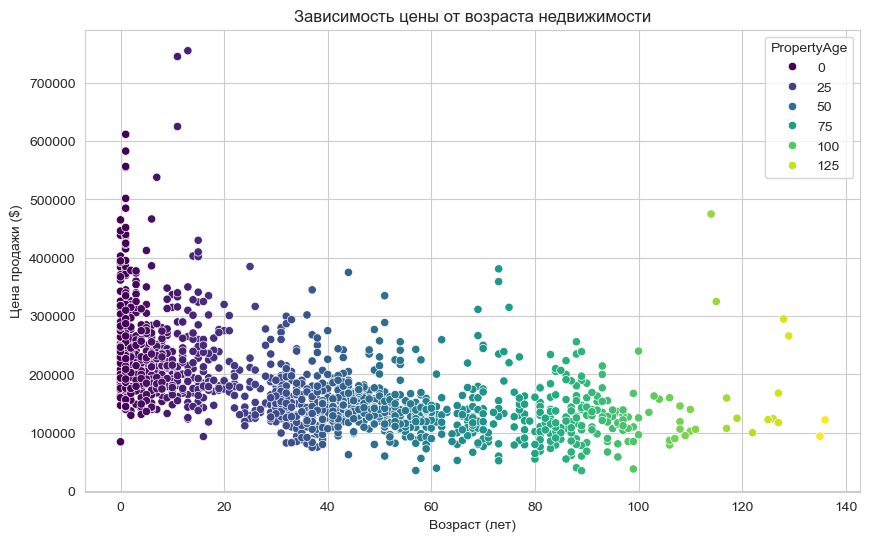

In [59]:
# 5. Возраст недвижимости и цена
train['PropertyAge'] = train['YrSold'] - train['YearBuilt']
age_price_corr = train['PropertyAge'].corr(train['SalePrice'])
print(f'Корреляция между возрастом и ценой: {age_price_corr:.2f}')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PropertyAge', y='SalePrice', data=train,
                hue='PropertyAge', palette='viridis')
plt.title('Зависимость цены от возраста недвижимости')
plt.xlabel('Возраст (лет)')
plt.ylabel('Цена продажи ($)')
plt.show()

Корреляция между жилой площадью и ценой: 0.71


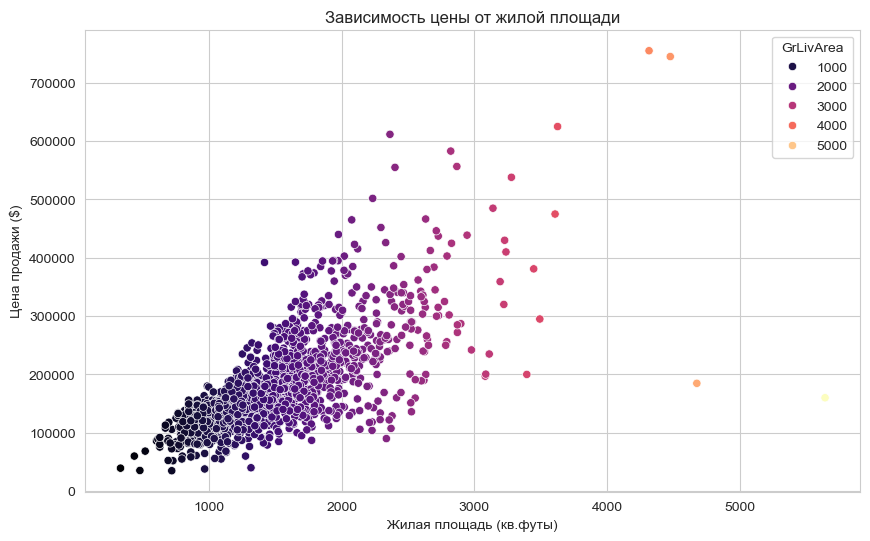

In [60]:
# 6. Жилая площадь и цена
living_area_corr = train['GrLivArea'].corr(train['SalePrice'])
print(f'Корреляция между жилой площадью и ценой: {living_area_corr:.2f}')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train,
                hue='GrLivArea', palette='magma')
plt.title('Зависимость цены от жилой площади')
plt.xlabel('Жилая площадь (кв.футы)')
plt.ylabel('Цена продажи ($)')
plt.show()

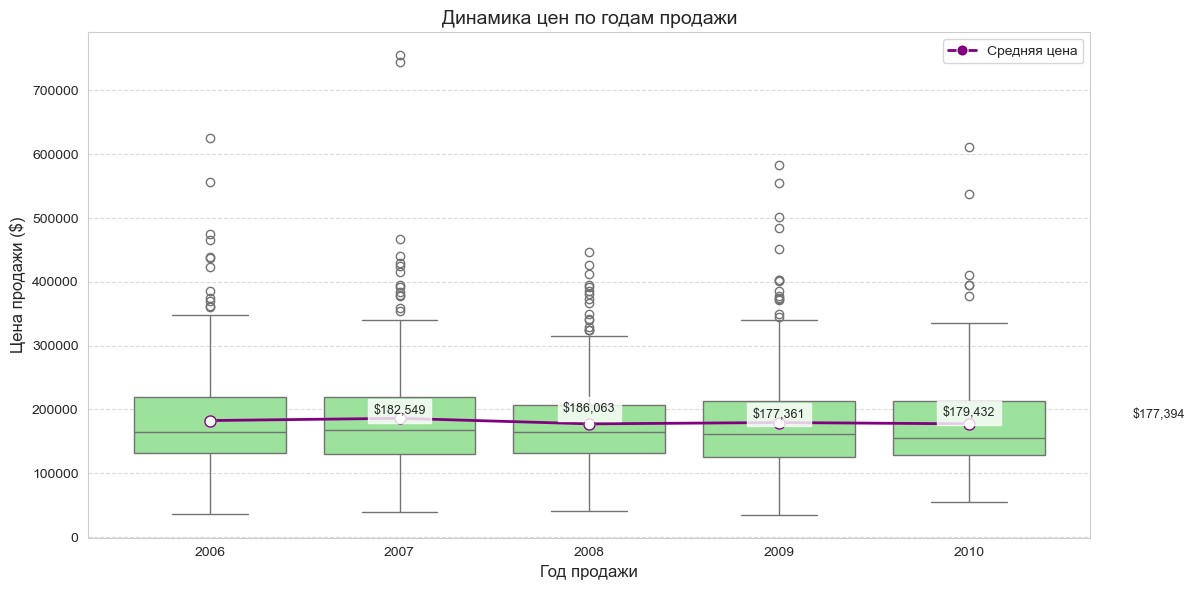

In [131]:
# 7. Динамика цен по годам
plt.figure(figsize=(12, 6))

sns.boxplot(x='YrSold', y='SalePrice', data=train,
            color='lightgreen', showmeans=True,
            meanprops={"marker": "o", "markerfacecolor": "white",
                       "markeredgecolor": "purple", "markersize": "8"})

yearly_avg = train.groupby('YrSold')['SalePrice'].mean()
sns.lineplot(x=yearly_avg.index.astype(str), y=yearly_avg.values,
             color='purple', linewidth=2, marker='o', markersize=8,
             label='Средняя цена')

for year, price in yearly_avg.items():
    plt.text(year - 2005, price + 5000, f'${price:,.0f}',
             ha='center', va='bottom', fontsize=9,
             bbox=dict(facecolor='white', alpha=0.8))

plt.title('Динамика цен по годам продажи', fontsize=14)
plt.xlabel('Год продажи', fontsize=12)
plt.ylabel('Цена продажи ($)', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Пайплайн

In [ ]:
!pip install category_encoders --user

In [306]:
from category_encoders import TargetEncoder, OrdinalEncoder, BinaryEncoder
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

encoders = {
    "OneHot": OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    "Target": TargetEncoder(),
    "Ordinal": OrdinalEncoder(),
    "Binary": BinaryEncoder(handle_unknown="ignore")
}

results = {}

for name, encoder in encoders.items():
    pipeline = Pipeline([
        ('encoder', encoder),
        ('scaler', StandardScaler()),  
        ('model', Ridge(alpha=1.0))  
    ])
    score = -cross_val_score(pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=5).mean()
    results[name] = score
    print(f"{name} Encoding MSE: {score:.5f}")


best_encoding = min(results, key=results.get)
print(f"\n✅ Лучший энкодер: {best_encoding} с MSE = {results[best_encoding]:.5f}")

OneHot Encoding MSE: 0.03804


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\2005k\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\2005k\miniconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\2005k\miniconda3\Lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "C:\Users\2005k\miniconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\2005k\miniconda3\Lib\site-packages\sklearn\linear_model\_ridge.py", line 1239, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "C:\Users\2005k\miniconda3\Lib\site-packages\sklearn\utils\validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\2005k\miniconda3\Lib\site-packages\sklearn\utils\validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\2005k\miniconda3\Lib\site-packages\sklearn\utils\validation.py", line 1107, in check_array
    _assert_all_finite(
  File "C:\Users\2005k\miniconda3\Lib\site-packages\sklearn\utils\validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "C:\Users\2005k\miniconda3\Lib\site-packages\sklearn\utils\validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
Ridge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [277]:
from sklearn.compose import ColumnTransformer

In [278]:
print("Колонки перед обработкой:", X_train.columns.tolist())

Колонки перед обработкой: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPo

In [279]:
numerical_cols = X_train_filtered.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train_filtered.select_dtypes(include=['object', 'category']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [280]:
pipeline.fit(X_train_filtered)

X_train_processed = pipeline.transform(X_train_filtered)
X_valid_processed = pipeline.transform(X_valid_filtered)

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train_filtered.index)
X_valid_processed = pd.DataFrame(X_valid_processed, columns=feature_names, index=X_valid_filtered.index)

y_valid_filtered = y_valid.loc[X_valid_processed.index]

In [281]:
print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"y_train_filtered shape: {y_train_filtered.shape}")

X_train_processed shape: (359, 134)
y_train_filtered shape: (359,)


## Обучение

In [282]:
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train_processed, y_train_filtered)

y_pred = model.predict(X_valid_processed)
mlse = mean_squared_error(y_valid_filtered, y_pred)
mlse

0.027638426497783683

In [309]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


def evaluate_model(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    mlse = mean_squared_error(y_valid, y_pred)
    return mlse


# Ridge Regression
#ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_params = {'alpha': np.logspace(-4, 3, 10)}
ridge = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_squared_log_error')
ridge_mlse = evaluate_model(ridge, X_train_processed, y_train_filtered, X_valid_processed, y_valid_filtered)

# Lasso Regression
#lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_params = {'alpha': np.logspace(-4, 3, 10)}
lasso = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='neg_mean_squared_log_error')
lasso_mlse = evaluate_model(lasso, X_train_processed, y_train_filtered, X_valid_processed, y_valid_filtered)

# ElasticNet
#elastic_params = {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}
elastic_params = {
    'alpha': np.logspace(-4, 3, 10),
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elastic = GridSearchCV(ElasticNet(), elastic_params, cv=5, scoring='neg_mean_squared_log_error')
elastic_mlse = evaluate_model(elastic, X_train_processed, y_train_filtered, X_valid_processed, y_valid_filtered)

# Polynomial Regression
poly_model = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1))
poly_mlse = evaluate_model(poly_model, X_train_processed, y_train_filtered, X_valid_processed, y_valid_filtered)

print(f"Ridge MLSE: {ridge_mlse:.4f}")
print(f"Lasso MLSE: {lasso_mlse:.4f}")
print(f"ElasticNet MLSE: {elastic_mlse:.4f}")
print(f"Polynomial Regression MLSE: {poly_mlse:.4f}")

C:\Users\2005k\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.350e-03, tolerance: 2.911e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\2005k\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.721e-03, tolerance: 3.019e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\2005k\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.277e-02, toler

Ridge MLSE: 0.0186
Lasso MLSE: 0.0157
ElasticNet MLSE: 0.0147
Polynomial Regression MLSE: 0.0231


In [310]:
print(f"Размер test.csv: {test.shape}")
print(f"Размер X_test_processed: {X_valid_processed.shape}")

Размер test.csv: (292, 80)
Размер X_test_processed: (90, 134)


In [311]:
print(f"Размер test.csv: {test.shape}")
print(f"Размер X_train_processed: {X_train_processed.shape}")
print(f"Колонки test:\n{test.columns}")
print(f"Колонки X_train_processed:\n{X_train_processed.columns}")

Размер test.csv: (292, 80)
Размер X_train_processed: (359, 134)
Колонки test:
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinis

In [312]:
test = pd.DataFrame(test, columns=test_columns)

X_test_processed = pipeline.transform(test)

X_test_processed = pd.DataFrame(X_test_processed, columns=X_train_processed.columns, index=test.index)
X_test_processed.fillna(0, inplace=True)
print(f"Обработанный X_test_processed: {X_test_processed.shape}")

AttributeError: This 'Pipeline' has no attribute 'transform'

In [313]:
best_model = lasso.best_estimator_
y_test_pred = best_model.predict(X_test_processed)

y_test_pred = np.expm1(y_test_pred)

submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': y_test_pred})

submission.to_csv('submission.csv', index=False)

print("Файл submission.csv сохранён!")

Файл submission.csv сохранён!
